In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


In [2]:
data = pd.read_csv("data_traj_escalade_v1.5.csv", sep=";", decimal=",")
time = data["Time"]
x = data["Marqueur 1/0/X"]
y = data["Marqueur 1/0/Y"]
data

,Time,Marqueur 1/0/X,Marqueur 1/0/Y
0,0.000,15.03189,-142.6752
1,0.033,15.00000,-142.0000
2,0.067,14.00000,-142.0000
3,0.100,14.00000,-142.0000
4,0.133,14.00000,-142.0000
...,...,...,...
4908,174.861,54.00000,-153.0000
4909,174.895,56.00000,-153.0000
4910,174.928,57.00000,-154.0000
4911,174.961,60.00000,-154.0000


In [3]:
# j'identifie la montée et la descente en obtenant les index de la coordonnées y (axe vertical) la plus haute atteinte.
np.where(data["Marqueur 1/0/Y"] == np.max(data["Marqueur 1/0/Y"]))

(array([3429, 3430, 3431, 3432]),)

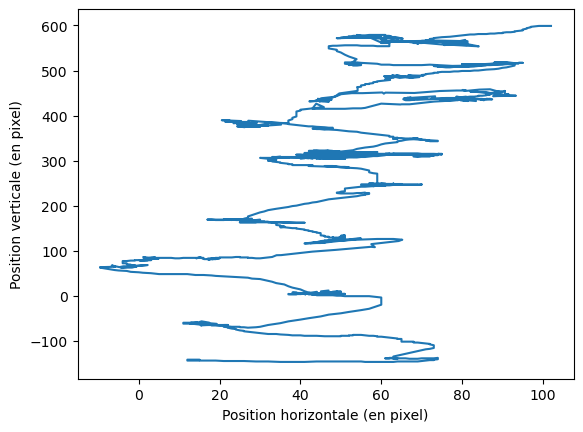

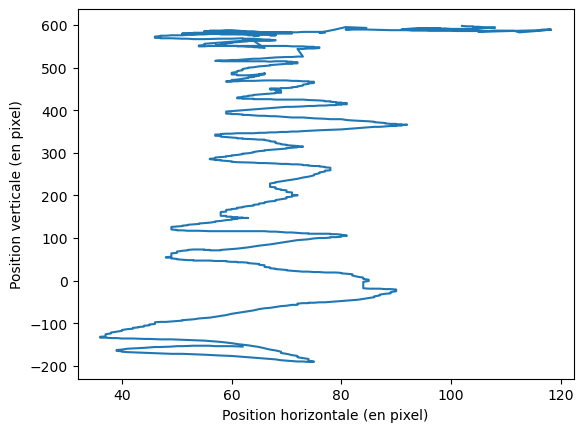

In [4]:
plt.plot(x[:3433], y[:3433])
plt.xlabel("Position horizontale (en pixel)")
plt.ylabel("Position verticale (en pixel)")
plt.savefig("traj_montee.svg")
plt.show()
plt.plot(x[3433:], y[3433:])
plt.xlabel("Position horizontale (en pixel)")
plt.ylabel("Position verticale (en pixel)")
plt.savefig("traj_descente.svg")

In [5]:
data.iloc[180]

Time               5.998
Marqueur 1/0/X    53.000
Marqueur 1/0/Y   -87.000
Name: 180, dtype: float64

## La vitesse
Pour connaitre la vitesse en mètre par seconde, il est nécesssaire de convertir les distances en mètre, pour celà a été pris la mesure de la distance entre mes pieds et le point de référence au début de la vidéo sur kinovéa. Cette distance s'est avéré être de 165,42 pixels correspondant après mesure avec un mètre à 100 centimètre. Nous pouvons donc obtenir par un simple produit en croix que $1 cm = 1 * 165,42/100$ pixels ce qui donne 1,6542 pixels. Nous devons donc diviser chaque distance par 1,6542 pour obtenir le résultat en cm. Le temps quand à lui est en secondes. La différence de temps entre chaque mesures est, d'après une simple lecture des premières données d'environ 0,033 secondes, il faut environ 30 mesures $(1/0,033)$ pour avancer d'une seconde. Les positions dont nous mesurons la distance correspondent donc à celle de la mesure x et de la mesure $x+30$. Il suffit ensuite de faire une moyenne des vitesses mesurées lors de la montée en centimètres par secondes. Nous tentons en ensuite de convertir la vitesse en km/h, $1 km = 100 000 cm$ donc on commence par diviser par 100 000, par ailleurs 1 heure = 3600 secondes donc on multiplie par 3600, on a donc $1 cm/s = (1/100 000)*3600 = 0,036 km/h$, il suffit donc de multiplier les cm/s par 0,036 pour obtenir la vitesse en km/h.

np.float64(0.2778923219981999)

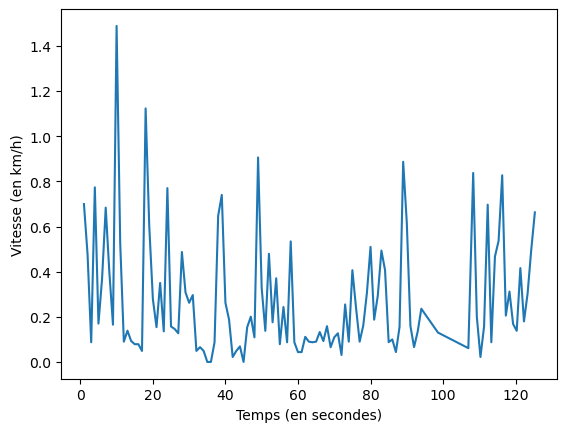

In [6]:
i = 0
vitesses_par_seconde = []
time_v = []
# 3402 = fin de la montée-30
while i <= 3402:
    time_a, x_a, y_a = data.iloc[i]
    time_b, x_b, y_b = data.iloc[i+30]
    dist_en_cm = (np.sqrt((x_b-x_a)**2+(y_a-y_b)**2))/1.6542
    vitesses_par_seconde.append(dist_en_cm/(time_b-time_a)) # vitesse en cm/s
    time_v.append(time.iloc[i+30])
    i+=30

plt.plot(time_v, np.array(vitesses_par_seconde)*0.036)
plt.xlabel("Temps (en secondes)")
plt.ylabel("Vitesse (en km/h)")
plt.savefig("speed.svg")

np.mean(np.array(vitesses_par_seconde))*0.036 # vitesse moyenne en km/h

La vitesse obtenue est donc d'environ 0,28 km/h. Dans la mesure où, sur la vidéo nous pouvons voir que je suis assez lente et que par ailleurs je fais beaucoup de pause et j'hésite à monter, cette vitesse moyenne pourrait être cohérente. Elle l'est en tout cas plus que celle trouvée lors du premier rapport qui mesurait jusqu'à 10 000 m/s ($= 10 000*3,6 = 36 000 km/h$ (on divise par 1000 pour que ce soit en km et on multiplie par 3600 pour que ce soit en heure ce qui revient à faire $x*(3600/1000)=x*3,6)$) ce qui était totalement invraissemblable.

## Temps d'escalade

In [7]:
time[3432]

np.float64(125.648)

Pour mesurer le temps d'escalade il suffit tout simplement de regarder la valeur à l'index 3432 du tableau time correspondant au temps passé depuis le début quand nous avons atteint le point le plus haut sur l'axe vertical, c'est à dire le haut du mur. Que ce soit pour ce rapport où le rapport précédent, la mesure du temps était cohérente.

## Ratio temps de mouvements sur temps d'immobilité

In [8]:
def isclose(a, b, trsh):
    return abs(a-b)<trsh
trsh = 1
index_deb = time[(isclose(time, 11.23, trsh))]
index_fin = time[(isclose(time, 17.33, trsh))]
while len(index_deb) > 1:
    trsh/=10
    index_deb = time[(isclose(time, 11.23, trsh))]
trsh = 1
while len(index_fin) > 1:
    trsh/=10
    index_fin = time[(isclose(time, 17.33, trsh))]
index_deb = index_deb.index[0]
index_fin = index_fin.index[0]
index_deb, index_fin

(np.int64(337), np.int64(520))

In [9]:
i = 0
dist_imo = []
while i < len(data[index_deb:(index_fin+1)])-30:
    time_a, x_a, y_a = data.iloc[i]
    time_b, x_b, y_b = data.iloc[i+30]
    dist_imo.append((np.sqrt((x_b-x_a)**2+(y_a-y_b)**2))/1.6542)
    i+=30
trsh = np.mean(np.array(dist_imo))
trsh

np.float64(11.916358817123998)

In [10]:
i = 0
mouvement = []
while i <= (len(time)-30):
    time_a, x_a, y_a = data.iloc[i]
    time_b, x_b, y_b = data.iloc[i+30]
    dist_en_cm = (np.sqrt((x_b-x_a)**2+(y_a-y_b)**2))/1.6542
    if dist_en_cm > trsh:
        mouvement.append(True)
    else:
        mouvement.append(False)
    i+=30
mouvement_def = []
for j in mouvement:
    for k in range(30):
        mouvement_def.append(j)
if i < len(time):
    diff = len(time)-i
    for j in range(diff):
        mouvement_def.append(mouvement_def[-1])
f"{round(((len(time[(np.array(mouvement_def))])*0.033)-0.033)/(time[3432])*100, 2)} %"

'43.13 %'

Pour trouver les temps d'immobilités, nous avons identifiés visuellement entre 11.23 secondes et 17.33 secondes un temps d'immobilité. Nous allons donc chercher les index correspondant le plus à ces timecode puis mesurer la distance moyenne considérée comme parcourue sur cet interval et considérer ensuite que toute distance parcourue supérieure à cette distance moyenne correspond à du mouvement.
Pour chaque intervalle de 1 seconde environ où on considère qu'il y a du mouvement, on ajoute True dans le tableau mouvement pour l'indiquer sinon on ajoute false. Ensuite, nous créons un 2e tableau mais où chaque élément est présent 30 fois pour correspondre aux 30 index sautés pour faire nos mesures sur un intervalle de 1 seconde. Enfin on vérifie que le tableau définitif contient bien le même nombre d'éléments que *time* et si ce n'est pas le cas, on ajoute le dernier élément du tableau. C'est nécessaire car soit un tableau numpy quelconque arr et un tableau de booléen, arr\[(cond)\] ne renvoie que les éléments de arr pour lequel cond est égal à True, en l'occurence correspondant aux moments où on est en mouvement. Chaque éléments de ce tableau correspondants à 0,033 secondes on multiplie la taille du tableau obtenu par 0,033 puis on soustrait une fois 0,033 puisque au premier élément du tableau 0 secondes se sont passées. On répète le même processus avec tous le tableau du temps. On fait ensuite le rapport entre les 2 chiffres obtenus puis on multiplie par 100 pour obtenir le pourcentage. Nous obtenons donc 33.43%, ça parait peu dans la mesure où dans le dernier rapport avait été mesuré 45.54% de temps en mouvements alors même que je m'étais stoppée pendant de longue periode à plusieurs reprises. La méthode avec accéléromètre semble donc plus efficace pour mesurer l'abscence ou non de mouvement.

## Hauteur du mur

In [15]:
(np.mean(np.array(vitesses_par_seconde))/100)*(time[3432])

np.float64(9.699059576230507)

On sait que vitesse = distance/temps, ça signifie donc que distance = vitesse*temps. On a la vitesse en cm/s, il suffit de la diviser par 100 pour obtenir la vitesse en mètre par secondes. On multiplie la vitesse par le temps total d'escalade et on obtient un résultat d'environ 9,6 mètres. Ce résultat parait réaliste. Lors du dernier rapport il n'avais pas été possible de calculer la hauteur du mur dans la mesure où la vitesse n'était pas exploitable, l'utilisation de kinovea et du trackage est donc plus efficace pour cette mesure.